# Problem Description
In this problem, you will forecast the outcome of a portfolio of loans. Each loan is scheduled to be repaid over 3 years and is structured as follows:

#### Dataset
Each row corresponds to a loan, and the columns are defined as follows:

- The column with header `days since origination` indicates the number of days that elapsed between origination and the date when the data was collected.
- For loans that charged off before the data was collected, the column with header `days from origination to chargeoff` indicates the number of days that elapsed between origination and chargeoff.

#### Goal
We would like you to estimate **what fraction of these loans will have charged off by the time all of their 3-year terms are finished**.


Reference: https://rstudio-pubs-static.s3.amazonaws.com/203258_d20c1a34bc094151a0a1e4f4180c5f6f.html#feature-engineering

https://github.com/hlncrg/upStartDataChallenge/blob/master/upstartDataChallenge.ipynb

# Exploratory Data Analysis
#### Load libraries & Read data

In [39]:
%matplotlib inline
import pandas as pd
import numpy as np
from numpy import nan
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
from scipy.optimize import curve_fit

In [13]:
data = pd.read_csv('loan_timing.csv', header = 0)

Now I created a new column called "chargeoff" which is a dummy variable, where 1 means that loan has charged off and 0 otherwise. This can be used as the response variable if we want to build a model later.

I also created a column called "prop", which stores the fraction of loans that have charged off within that value of `days since origination`. For example, if `days since origination` equals 360, then 
$$prop = \frac{\text{number of chargeoffs with `days since origination`} < 360}{\text{number of total loans with `days since origination`}< 360}$$.

In [17]:
# new column
data['chargeoff'] = np.where(data['days from origination to chargeoff'] >= 0, 1, 0)

# another new column
prop = []
for index, row in data.iterrows():
    prop.append(float(data[(data["days since origination"] <= row["days since origination"]) & (data["chargeoff"] == 1)].shape[0])/float(data[data["days since origination"] <= row["days since origination"]].shape[0]))
    
data["prop"] = prop

Now let's look at part of the dataset.

In [65]:
data[11:16]

,days since origination,days from origination to chargeoff,chargeoff,prop
11,336,NaN,0,0.034858
12,51,NaN,0,0.006342
13,117,NaN,0,0.013592
14,327,78.0,1,0.033879
15,400,390.0,1,0.039781


#### What percentage of loans have been charged off when the data was collected?
We can tell that 3305 out of 50000 loans have been charged off, which is about 6.7%.

In [24]:
float(data[data["chargeoff"] == 1].shape[0])/ float(data.shape[0])

0.0661

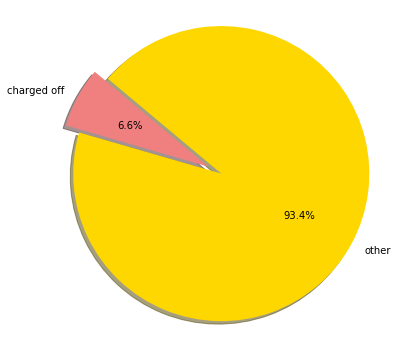

In [38]:
# pie chart
fig, ax = plt.subplots(figsize = (6, 6))
labels = "charged off", "other"
sizes = [3305, 50000 - 3305]
colors = ['lightcoral', 'gold']
explode = (0.1, 0) # explode chargedoff

plt.pie(sizes, explode = explode, labels = labels, colors = colors,
       autopct = '%1.1f%%', shadow = True, startangle = 140)
plt.axis('equal')
plt.show()

#### Histogram
Let's also have a look at the distribution of `days from origination to chargeoff`.

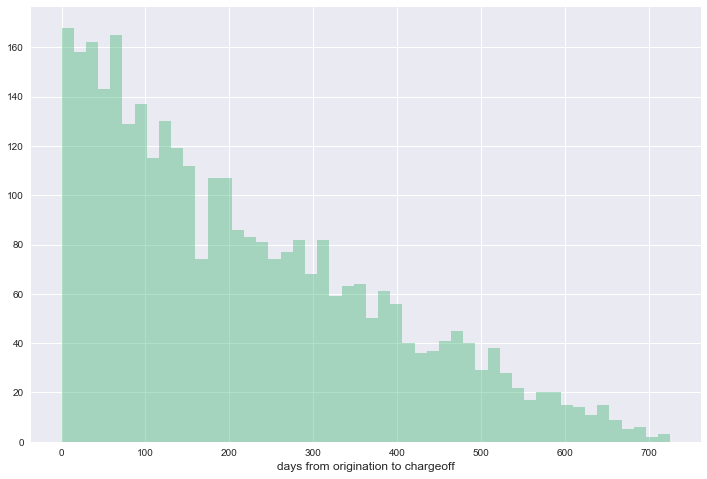

In [42]:
plt.figure(figsize = (12, 8))
sns.distplot(data[data["chargeoff"] == 1]["days from origination to chargeoff"], 
             bins = 50, kde = False, color = "mediumseagreen")
plt.xlabel('days from origination to chargeoff', fontsize = 12)
plt.show()

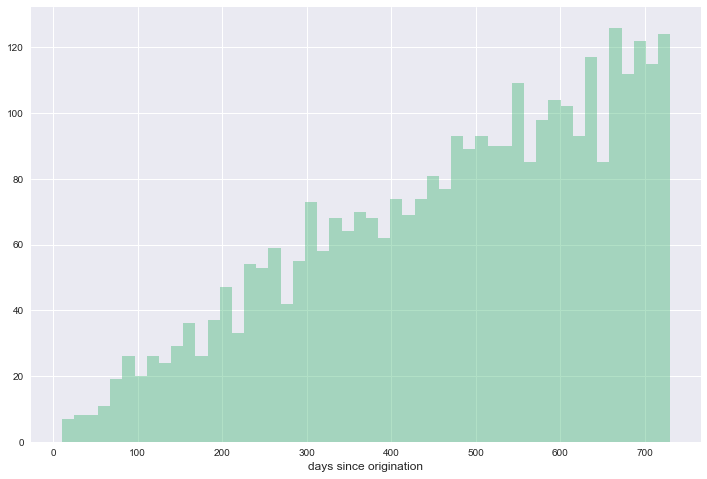

In [49]:
# distribution of loans that charge off
plt.figure(figsize = (12, 8))
sns.distplot(data[data["chargeoff"] == 1]["days since origination"], 
             bins = 50, kde = False, color = "mediumseagreen")
plt.xlabel('days since origination', fontsize = 12)
plt.show()

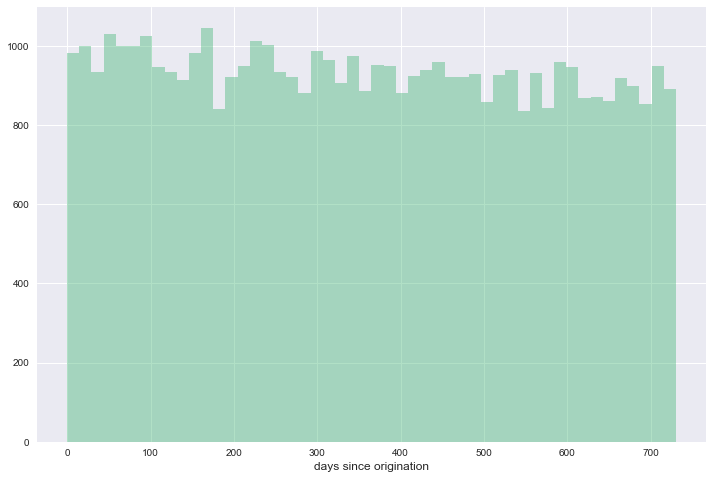

In [50]:
# distribution of loans that haven't charge off
plt.figure(figsize = (12, 8))
sns.distplot(data[data["chargeoff"] == 0]["days since origination"], 
             bins = 50, kde = False, color = "mediumseagreen")
plt.xlabel('days since origination', fontsize = 12)
plt.show()

It is obvious that the number of loans that charged off decreases as `days from origination to chargeoff` value increases, which means more people tend to charge off with short time after origination.

#### Chargeoff proportion vs. Days since origination

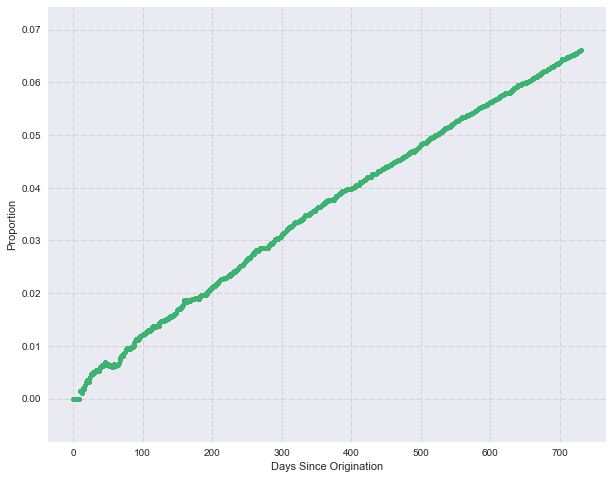

In [69]:
fig, ax = plt.subplots(figsize = (10, 8))
x = data['days since origination']
y = data['prop']
plt.scatter(x, y, s = 15, color = "mediumseagreen")

plt.xlabel('Days Since Origination')
plt.ylabel('Proportion')
plt.grid(color = 'lightgray', linestyle = '--')
plt.show()

We could see an almost perfect linear relationship between the two. One thing we could try is simple linear regression.

#### Chargeoff proportion vs. Days from origination to chargeoff

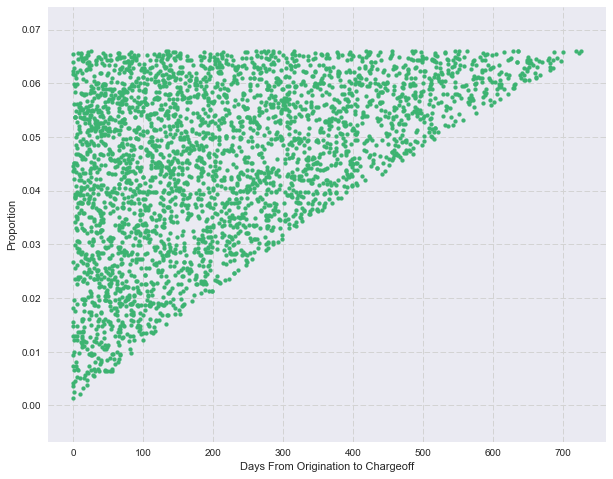

In [70]:
fig, ax = plt.subplots(figsize = (10, 8))
x = data['days from origination to chargeoff']
y = data['prop']
plt.scatter(x, y, s = 15, color = "mediumseagreen")

plt.xlabel('Days From Origination to Chargeoff')
plt.ylabel('Proportion')
plt.grid(color = 'lightgray', linestyle = '--')
plt.show()

I don't see a significant relationship through the scatter plot. I also look at the correlation plot. It also shows that there's no high correlation between the two. When we build the model later, we can assume these two variables are uncorrelated.

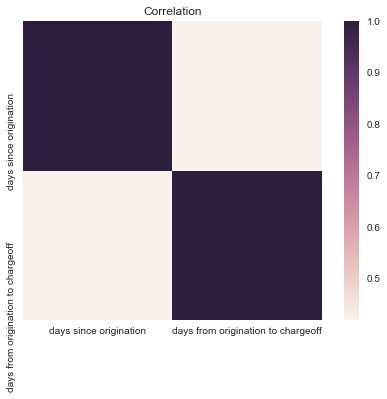

In [48]:
corrmat = data[["days since origination", "days from origination to chargeoff"]].corr(method = "spearman")

# heatmap
sns.heatmap(corrmat, vmax = 1., square = True)
plt.title("Correlation")
plt.show()

In [36]:
float(data[data["chargeoff"] == 1].shape[0])

3305.0